# Projet d'Implémentation des Méthodes d'Apprentissage Automatique

Dans ce projet, j'ai entrepris l'excitant défi de coder de zéro différentes méthodes d'apprentissage automatique, spécifiquement axées sur la classification. L'objectif était de comprendre en profondeur le fonctionnement de ces techniques et de les implémenter sans recourir à des bibliothèques externes telles que Scikit-Learn ou TensorFlow.

Pour ce faire, nous avons choisi d'utiliser trois datasets présentant des niveaux de difficulté variés : facile, moyen et difficile. Chacun de ces jeux de données contient uniquement deux caractéristiques (2D), ce qui permet une visualisation plus simple des données et une meilleure compréhension du fonctionnement des méthodes.

J'ai couvert un large éventail de méthodes de classification, notamment :

<strong>Classification par Distance :</strong> J'ai implémenté la classification basée sur des distances, en utilisant les métriques euclidienne et Mahalanobis. Ces méthodes sont essentielles pour la classification basée sur la proximité des points de données.

<strong>k Plus Proches Voisins (k-NN) :</strong> J'ai développé l'algorithme des k plus proches voisins, une méthode populaire qui classe les données en fonction des voisins les plus proches dans l'espace des caractéristiques.

<strong>Fenêtre de Parzen :</strong> J'ai créé une implémentation de la méthode de la fenêtre de Parzen, qui est une technique de classification basée sur l'estimation de densité.

<strong>Séparation Linéaire :</strong> J'ai travaillé sur la séparation linéaire, une technique qui vise à trouver un hyperplan de séparation pour les données.

<strong>SVM avec Kernel :</strong> J'ai mis en œuvre des Machines à Vecteurs de Support (SVM) avec différentes fonctions noyau, telles que le noyau linéaire, le noyau polynomial, et le noyau gaussien (RBF).

Dans le cadre de ce projet, j'ai également effectué le paramétrage de ces méthodes en utilisant des techniques de validation croisée pour optimiser leurs performances.

Ce projet m'a permis de plonger profondément dans les mathématiques, les concepts et les détails de chaque méthode, tout en acquérant une compréhension pratique de leur fonctionnement. J'ai également eu l'occasion de comparer les performances de ces implémentations avec des outils d'apprentissage automatique standard.

L'objectif de ce Jupyter Notebook est de documenter ces implémentations, d'expliquer le code et de fournir des exemples d'utilisation pour chaque méthode. J'espère que ce projet pourra servir de ressource pédagogique pour ceux qui cherchent à approfondir leur compréhension des méthodes d'apprentissage automatique.

N'hésitez pas à explorer chaque section pour en savoir plus sur les détails de chaque méthode et pour voir comment elles ont été mises en œuvre.

### Table of Contents

* [Classifieurs par distance](#EG)
    * [Classifieur par distance euclidienne](#DE)
    * [Classifieur par distance de Mahalanobis](#DM)
* [k-Plus Proche Voisin](#KNN)
    * [1-Plus Proche Voisin](#1KNN)
    * [KPPV avec vote à la majorité](#KNNmaj)
    * [KPPV avec vote à l'unanimité](#KNNuna)
* [Fenètres de Parzen](#parzen)
    * [$h=1$](#h1)
        * [Kernel Uniforme](#h1_uniform)
        * [Kernel Gaussien](#h1_gaussien)
    * [Selection de la valeur optimale de $h$](#hopt)
        * [Kernel Uniforme](#hopt_uniform)
        * [Kernel Gaussien](#hopt_gaussien)
* [Séparation Linaire](#SL)
    * [One vs One](#1v1)
    * [One vs all](#1vall)
* [SVM](#SVM)

In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold, cross_val_score

In [3]:
def visualize_data(testing_dataframe):
    n=testing_dataframe.index.size
    nbr_classe=len(testing_dataframe.Classe.unique())
    color_learn = ['gold','lightseagreen','royalblue','yellowgreen','purple']
    color_test = ['snow','gold','lightseagreen','royalblue','yellowgreen','purple']
    edge_color=['black','gold','lightseagreen','royalblue','yellowgreen','purple']
    plt.figure(figsize=(11,5))
    plt.subplot(1,2,1)
    for k in range(nbr_classe):
        plt.scatter(testing_dataframe.loc[testing_dataframe.Classe==k+1,'x1'],testing_dataframe.loc[testing_dataframe.Classe==k+1,'x2'],c=color_learn[k],label=k+1)
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.legend()
    plt.subplot(1,2,2)
    for k in range(nbr_classe+1):
        if k == 0:
            label="NC"
        else: label = k
        plt.scatter(testing_dataframe.loc[testing_dataframe.top1==k,'x1'],testing_dataframe.loc[testing_dataframe.top1==k,'x2'],c=color_test[k],edgecolors=edge_color[k],label=label)
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.legend()
    return

def top_one(testing_dataframe):
    n=testing_dataframe.index.size
    nbr_classe=len(testing_dataframe.Classe.unique())
    top1=0
    for i in range(n):
        if testing_dataframe.iloc[i,0]==testing_dataframe.iloc[i,3]:
            top1+=1
    return top1/n*100

def top_two(testing_dataframe):
    n=testing_dataframe.index.size
    nbr_classe=len(testing_dataframe.Classe.unique())
    top2=0
    for i in range(n):
        if testing_dataframe.iloc[i,0] in testing_dataframe.iloc[i,4]:
            top2+=1
    return top2/nbr_classe

def mat_confusion(testing_dataframe,plot=True):
    n=testing_dataframe.index.size
    nbr_classe=len(testing_dataframe.Classe.unique())
    labels=[i+1 for i in range(nbr_classe+1)]
    labels[nbr_classe]='NC'
    mat_c=np.zeros((nbr_classe,nbr_classe+1))
    exp_non_classe=False
    for i in range(n):
        if testing_dataframe.iloc[i,3]==0: # si l'exemple n'est pas classé
            exp_non_classe=True
            mat_c[int(testing_dataframe.iloc[i,0])-1,nbr_classe]+=1
        else:
            mat_c[int(testing_dataframe.iloc[i,0])-1,int(testing_dataframe.iloc[i,3])-1]+=1
    if plot==True:
        plt.figure()
        if exp_non_classe==True:
            sn.heatmap(mat_c,cmap=sn.cubehelix_palette(as_cmap=True),annot=True,fmt='.0f',xticklabels=labels,yticklabels=labels[:-1])
        else:
            sn.heatmap(mat_c[:,:-1],cmap=sn.cubehelix_palette(as_cmap=True),annot=True,fmt='.0f',xticklabels=labels[:-1],yticklabels=labels[:-1])
    return mat_c

In [4]:
data_app_1=pd.read_csv("data/data_train1.txt",sep=' ',names=['Classe','x1','x2'],header=None)
data_app_2=pd.read_csv("data/data_train2.txt",sep=' ',names=['Classe','x1','x2'],header=None)
data_app_3=pd.read_csv("data/data_train3.txt",sep=' ',names=['Classe','x1','x2'],header=None)

data_test_1=pd.read_csv("data/data_test1.txt",sep=' ',names=['Classe','x1','x2'],header=None)
data_test_2=pd.read_csv("data/data_test2.txt",sep=' ',names=['Classe','x1','x2'],header=None)
data_test_3=pd.read_csv("data/data_test3.txt",sep=' ',names=['Classe','x1','x2'],header=None)

# 1. Classifieurs par distance <a class="anchor" id="EG"></a>

## Code

Afin de coder l'estimation gaussienne avec distance euclidienne et distance de Mahalanobis, nous utilisons la classe *estimation_gaussienne*. La méthode *learning* permet de faire l'apprentissage, elle a pour entré le jeu de données (en dataframe). La méthode *testing* quand elle permet de classifier, elle a pour entrée le jeu de données à classifier ainsi que le nom de la méthode à utiliser pour le calcul des distances (*distance_euclidienne* ou *distance_mahalanobis*)

In [4]:
def distance_euclidienne(x,y,mat_cov=0):
    return math.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2)

def distance_mahalanobis(x,y,mat_cov):
    return np.dot(np.dot((x-y).T,np.linalg.inv(mat_cov)),(x-y))

class estimation_gaussienne:
    def learning(self, learning_dataframe):
        mu=[]
        mu_i=np.zeros(2)
        nbr_classe=len(learning_dataframe.Classe.unique())
        mat_cov=np.zeros((nbr_classe,2,2))
        for i in range(nbr_classe): # calcule des centroides et des matrices de co-variance de chaque classes
            mu_i[0] = learning_dataframe.loc[learning_dataframe.Classe == i+1, 'x1'].mean()
            mu_i[1] = learning_dataframe.loc[learning_dataframe.Classe == i+1, 'x2'].mean()
            mu.append(mu_i.copy())
            mat_cov[i]=np.cov(learning_dataframe.loc[learning_dataframe.Classe == i+1,['x1','x2']].T)
        return mu, mat_cov
    
    def testing(self, testing_dataframe,distance_function,mu,cov):
        nbr_classe=len(mu)
        n=testing_dataframe.index.size
        
        # pour chaque exemple à classifier calculer la probabilité d'apprentenir à une classe
        proba=np.zeros((n,nbr_classe))
        for i in range(n):
            for j in range(nbr_classe):
                proba[i,j]=np.exp(-distance_function(testing_dataframe.iloc[i,1:3].values.T,mu[j],cov[j]))
        result=testing_dataframe.copy()
        result['top1']=pd.Series(np.argmax(proba,axis=1)+1).values
        result['top2']=pd.Series(np.ndarray.tolist(np.argsort(proba,axis=1)[:,-1:-3:-1]+1)).values
        return result

## Test classifieur par distance euclidienne minimum <a class="anchor" id="DE"></a>

#### Données N° 1 (dist eucl)

Top 1 =  99.2
Top 2 =  100.0


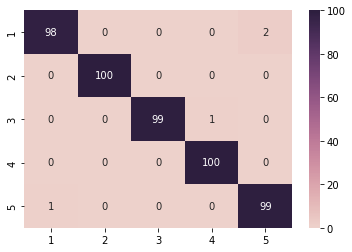

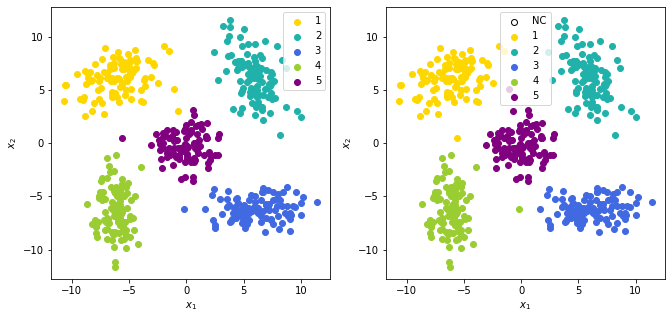

In [14]:
EGE = estimation_gaussienne()
mu, cov = EGE.learning(data_app_1)
result=EGE.testing(data_test_1,distance_euclidienne,mu,cov)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°2 (dist eucl)

Top 1 =  94.6
Top 2 =  99.6


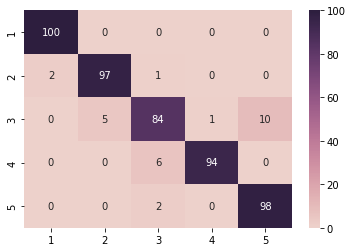

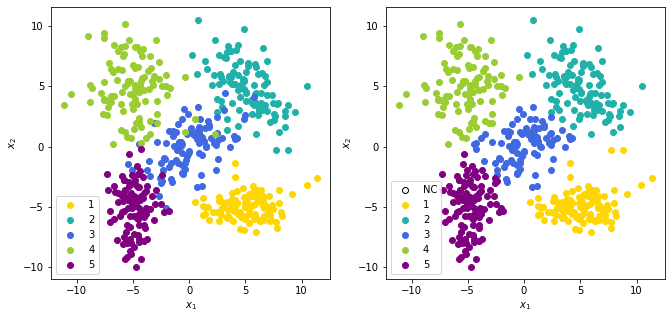

In [13]:
EGE = estimation_gaussienne()
mu, cov = EGE.learning(data_app_2)
result=EGE.testing(data_test_2,distance_euclidienne,mu,cov)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°3 (dist eucl)

Top 1 =  72.8
Top 2 =  89.2


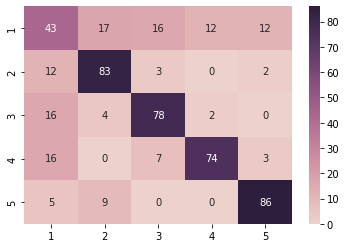

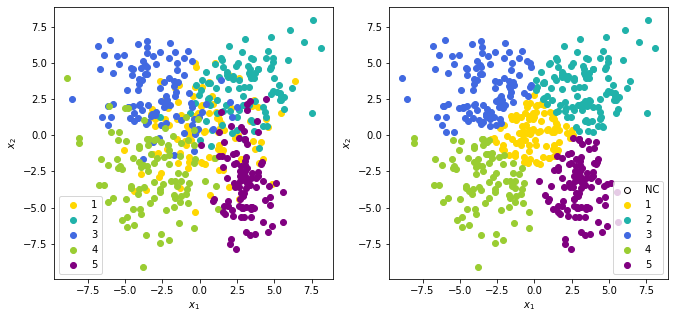

In [64]:
EGE = estimation_gaussienne()
mu, cov = EGE.learning(data_app_3)
result=EGE.testing(data_test_3,distance_euclidienne,mu,cov)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Conclusion (classifieur par distance euclidienne minimum)

Le classifieur par distance euclidienne minimum donne de bon résultats en top 1 avec respectivement 99,2% et 94,6% pour les données N°1 et N°2. Cependant, pour le jeu de données N°3 le taux de bonne réponse en top 1 s'effondre à 72.8%, ce qui est en soit pas mauvais en vue de la complexités de classifier les données N°3. De plus, la méthode s'en sort avec un bon taux de précision en top 2 est de 89.2% pour les données N°3.

## Test classifieur par distance de Mahalanobis minimum <a class="anchor" id="DM"></a>

#### Données N°1 (dist Mahalanobis)

Top 1 =  99.6
Top 2 =  99.8


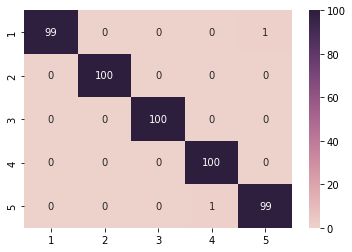

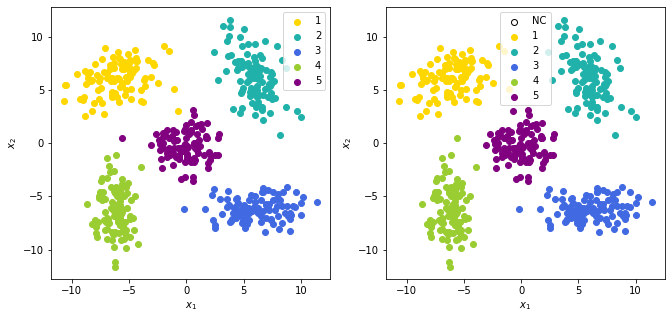

In [61]:
EGE = estimation_gaussienne()
mu, cov = EGE.learning(data_app_1)
result=EGE.testing(data_test_1,distance_mahalanobis,mu,cov)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°2 (dist Mahalanobis)

Top 1 =  95.39999999999999
Top 2 =  99.4


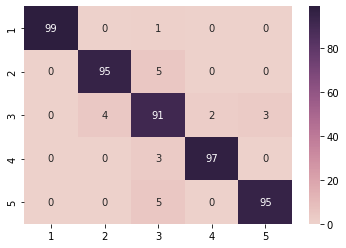

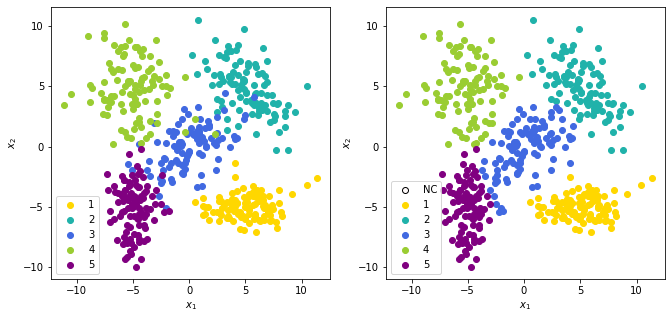

In [66]:
EGE = estimation_gaussienne()
mu, cov = EGE.learning(data_app_2)
result=EGE.testing(data_test_2,distance_mahalanobis,mu,cov)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°3 (dist Mahalanobis)

Top 1 =  69.39999999999999
Top 2 =  87.0


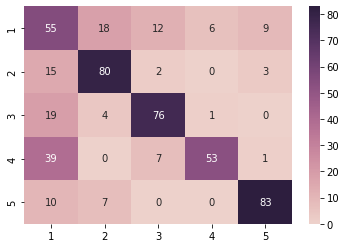

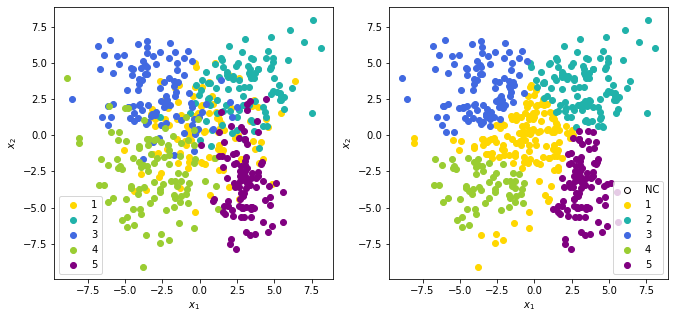

In [67]:
EGE = estimation_gaussienne() 
mu, cov = EGE.learning(data_app_3) 
result=EGE.testing(data_test_3,distance_mahalanobis,mu,cov)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Conclusion (classifieur par distance de mahalanobis minimum)

Le classifieur par distance de mahalanobis minimum à d'excellent résultat pour les jeu de données N°1 et N°2 avec des taux de donne prédiction respectifs de  99,6% et 95,4%. Cependant, pour les données N°3 le taux de prédiction en top 1 baisse à 69,4% et le top 2 à 87%.

### Comparaison des deux méthode (Euclidienne vs Mahalanobis)

Lorsqu'on compare les deux méthodes, il est évident que le classifieur par distance de mahalanobis minimum est meilleur que le classifieur par distance euclidienne minimum sur les deux premiers jeux de données. Cependant, pour le troisième jeu de données le classifieur par distance euclidienne donnent de meilleures prédictions. Mais en globalité les deux méthodes donne des résultats assez similaires.

# 2. k- Plus Proche Voisin (KNN) <a class="anchor" id="KNN"></a>

## Code

In [11]:
def folding_data(learning_dataframe,fold=5):#diviser le data set en fold 
    X=learning_dataframe.values #recupérer les données du data frame dans un ndarray
    n=X.shape[0] #taille du jeux de données
    n_fold=int(n/5) #taille de chaque fold
    X=np.c_[learning_dataframe.index.values,X,np.ones(n)] #rajouter un colonne pour y mettre le N° du fold
    
    np.random.shuffle(X) #melanger les lignes des données alétoirement
    
    for i in range(fold): # pour que chque fold
        for j in range(n_fold): # pour chaque élément du fold
            X[i*n_fold+j,4]=i # faire un tirage aléatoire d'u, élément et l'affecter à un fold
    df = pd.DataFrame(X[:,1:], columns=['Classe','x1','x2','fold']) # remettre les données dans un dataframe
    df = df.astype({'Classe': int})
    return df

class kppv:
    def testing(self,learning_dataframe,testing_dataframe,k=1,unanimite=0): #classifier les données
        nbr_classe=len(learning_dataframe.Classe.unique()) #récupérer le nombre de classes
        n_test=testing_dataframe.index.size #récupérer le nombre d'exeples dan les data d'apprentissage
        n_learn=learning_dataframe.index.size #récupérer le nombre d'exepmples dans les data de test
        
        learning_dataframe.index=np.arange(n_learn) #réindexer les dataframe à partir de 0 dans le cas de cross validation
        testing_dataframe.index=np.arange(n_test)
        
        P=np.zeros((n_test,n_learn)) #création de la matrice des probabilités
        class_percentage=np.zeros((n_test,nbr_classe)) #création de la matrice qui va contenir le pourcentage de chaque classe dans le k voisinage de chaque exemple qu'on souhaite classé
        
        ########### Calcule des probabilités (Distances) ############
        for i in range(n_test): #pour chaque éléments à classifier
            x=testing_dataframe.iloc[i,1:3].values 
            for j in range(n_learn): #calcule de la probabilités (distance) entre l'exemple à classifier et les exemples d'apprentissage
                y=learning_dataframe.iloc[j,1:3].values 
                P[i,j]=np.exp(-distance_euclidienne(x, y))

        ############################################################
        
        #################### Identifier les classes des KPPV et procéder au votes ######################
        C=np.argsort(P,axis=1)[:,-1:-k-1:-1] # récupérer l'argument des k voisins qui ont la plus grande proba
        L_top1=[] #liste qui va contenir la classes top1
        L_top2=[] #liste qui va contenir les classes top2
        for i in range(n_test):
            for j in range(k):
                C[i,j]=learning_dataframe.iloc[C[i,j],0]-1 # C va contenir le numéro de la classe de chacun des k voisins
            class_percentage[i,:]=np.bincount(C[i,:],minlength=nbr_classe)/k # Calculer le pourcentage de présence de chaque classe dans le k voisinage de l'élément à classifier
            nb=min(2,np.count_nonzero(class_percentage[i,:])) # dans le cas ou une seule classe est présente dans le k voisinage il n'y a pas de top2
            if max(class_percentage[i,:])>=unanimite: # vote à lunanimité (si unanimité=0 alors le vote se fait par méjorité)
                L_top1.append(np.argmax(class_percentage[i,:])+1) # ajouter la classe top1
                L_top2.append(np.ndarray.tolist(np.argsort(class_percentage[i,:])[-1:-nb-1:-1]+1)) #ajouter la ou les deux classes top2
            else: # si il n'y a pas d'unanimité dans le vote alors l'exemple n'est pas classifier
                L_top1.append(0)
                L_top2.append([])
        result=testing_dataframe.copy()
        result['top1']=pd.Series(L_top1)
        result['top2']=pd.Series(L_top2)
        return result
    
    def cross_validation(self,folded_dataframe,fold,k_range,unanimite=0): # après avoir diviser le dataframe en plusieurs fold, nous allons faire une rotation de ces fold (1 fold pour le test et le reste des fold pour l'apprentissage)
        top_fold=np.zeros(k_range)
        nbr_classe=len(folded_dataframe.Classe.unique())
        for i in range(fold):
            for k in range(k_range):
                result=KNN.testing(fold_dataframe.loc[fold_dataframe.fold != i,['Classe','x1','x2']], fold_dataframe.loc[fold_dataframe.fold == i,['Classe','x1','x2']],k=k+1,unanimite=unanimite)
                top_fold[k]+=top_one(result) #calculer le taux de bonne prédiction pour chaque valeur de k
        k_opt = np.argmax(top_fold)+1
        return k_opt # retourne la valeur optimale de k (qui a le taux de bonne prédiction le plus élevé)

## 1PPV test <a class="anchor" id="1KNN"></a>

#### Données N°1 (1PPV)

Top 1 =  99.2


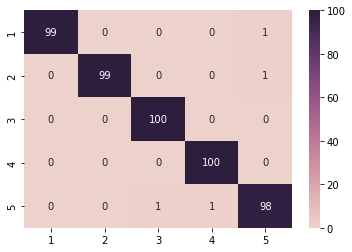

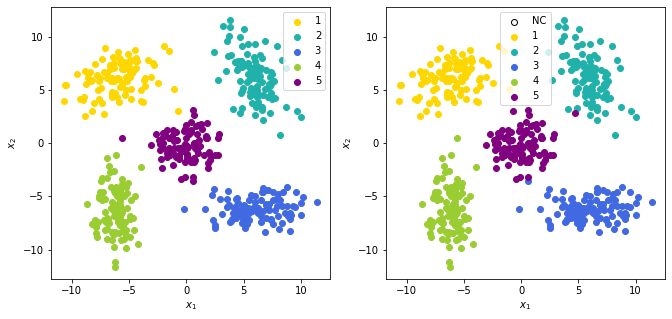

In [70]:
KNN=kppv()
result=KNN.testing(data_app_1,data_test_1,k=1,unanimite=0)
mat_conf=mat_confusion(result)
print("Top 1 = ",top_one(result))
visualize_data(result)

#### Données N°2 (1PPV)

Top 1 =  92.0


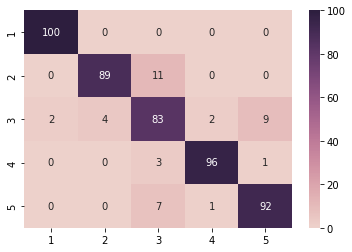

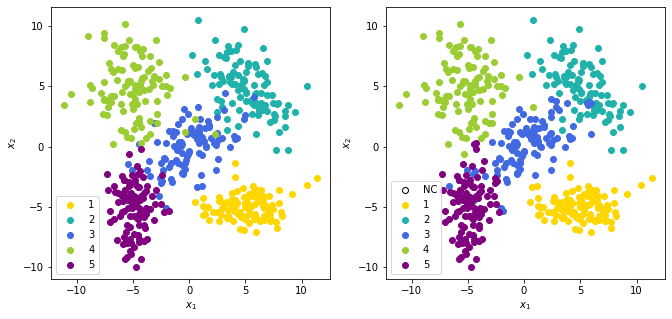

In [65]:
KNN=kppv()
result=KNN.testing(data_app_2,data_test_2,k=1,unanimite=0)
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°3 (1PPV)

Top 1 =  64.6


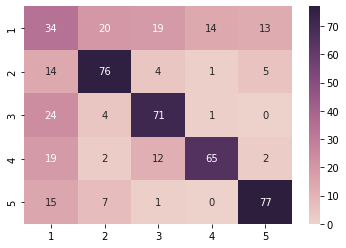

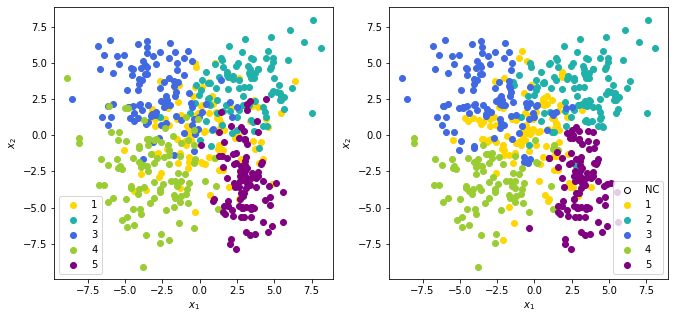

In [66]:
KNN=kppv()
result=KNN.testing(data_app_3,data_test_3,k=1,unanimite=0)
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Conclusion (1PPV)

La méthode de 1PPV donne de bon résultat pour les données N°1 et N°2 avec un taux de bonne prédiction en top 1 respectif de 99,2% et 92%. Pour les données N°3, les résultats sont très moyens avec un taux de bonne prédiction de 64,6% seulement.

## KPPV vote à la majorité test <a class="anchor" id="KNNmaj"></a>

#### Données N°1 (KPPV maj)

Déterminer le k optimale par 5CV

In [144]:
KNN=kppv()
fold_dataframe=folding_data(data_app_1,fold=5)
k_opt=KNN.cross_validation(fold_dataframe, fold=5, k_range=20, unanimite=0) 
print("k*=",k_opt)

k*= 7


Tester la méthode avec le k optimale

Top 1 =  99.6
Top 2 =  99.6


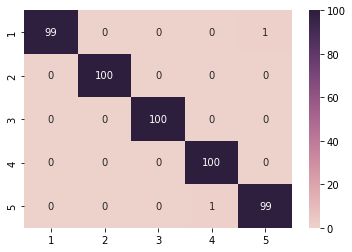

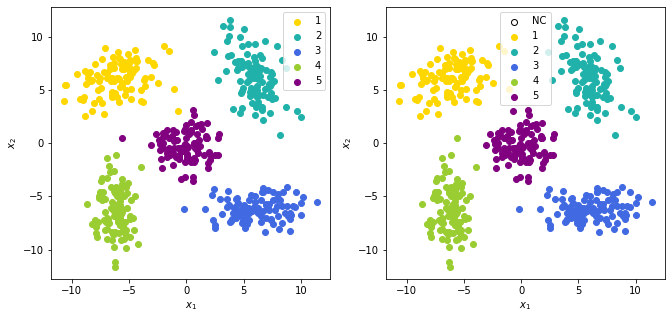

In [145]:
result=KNN.testing(data_app_1,data_test_1,k=k_opt,unanimite=0)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°2 (KPPV maj)

Déterminer le k optimale par 5CV

In [92]:
KNN=kppv()

fold_dataframe=folding_data(data_app_2,fold=5)
k_opt=KNN.cross_validation(fold_dataframe, fold=5, k_range=20, unanimite=0)
print("k*=",k_opt)

k*= 12


Tester la méthode avec le k optimale

Top 1 =  95.2
Top 2 =  99.0


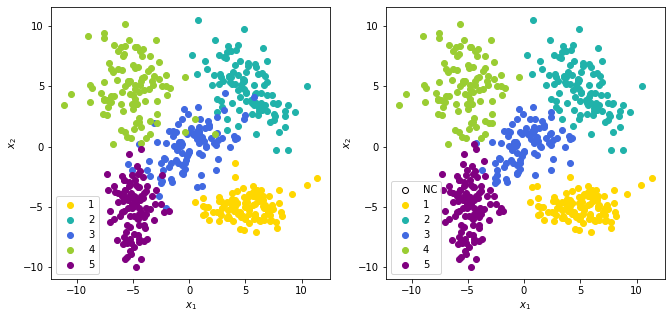

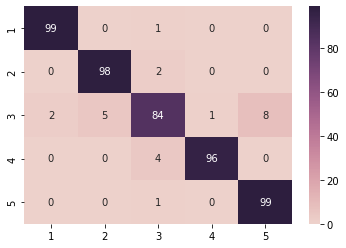

In [93]:
result=KNN.testing(data_app_2,data_test_2,k=k_opt,unanimite=0)
visualize_data(result)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)

#### Données N°3 (KPPV maj)

Déterminer le k optimale par 5CV

In [94]:
KNN=kppv()

fold_dataframe=folding_data(data_app_3,fold=5)
k_opt=KNN.cross_validation(fold_dataframe, fold=5, k_range=20, unanimite=0)
print("k*=",k_opt)

k*= 8


Tester la méthode avec le k optimale

Top 1 =  69.6
Top 2 =  84.4


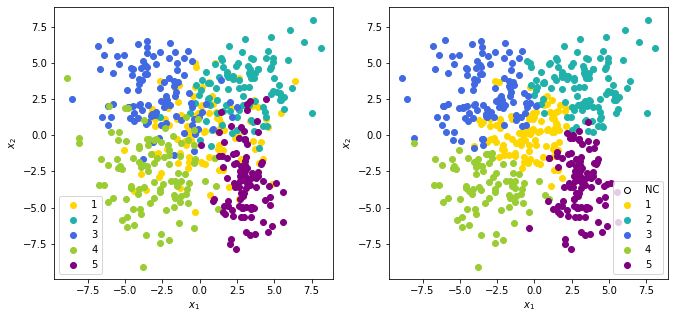

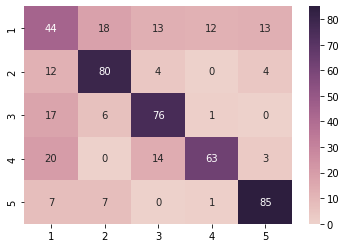

In [95]:
result=KNN.testing(data_app_3,data_test_3,k=k_opt,unanimite=0)
visualize_data(result)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)

#### Conclusion (KPPV maj)

La méthode KPPV avec vote à la majorité donne d'excellent résultats pour les données N°1 et N°2 avec un taux de prédiction respectif de 99,6% $(k=5)$ et 94,8% $(k=18)$. Le taux de prédiction en top 1 baisse à 69,6% du au très faible taux de bonne prédiction de la classe centrale qui est difficile à classifier car elle se trouve dans une régions ou toutes les classes sont présentes. Cependant, un bien meilleur taux de prédiction en top 2 est enregistré (84,8%).

## KPPV vote à l'unanimité test <a class="anchor" id="KNNuna"></a>

#### Données N°1 (KPPV una)

Déterminer le $k$ optimale par 5CV

In [96]:
KNN=kppv()

fold_dataframe=folding_data(data_app_1,fold=5)# diviser les données d'apprentissage en 5 sous ensembke
k_opt=KNN.cross_validation(fold_dataframe, fold=5, k_range=20, unanimite=1) # déterminer k par un 5CV sur les données d'apprentissage
print("k*=",k_opt)

k*= 1


Tester la méthode avec le k optimale

Top 1 =  99.2


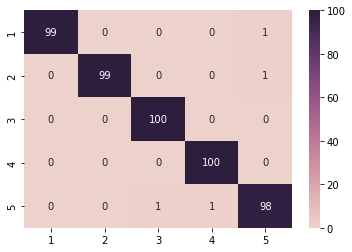

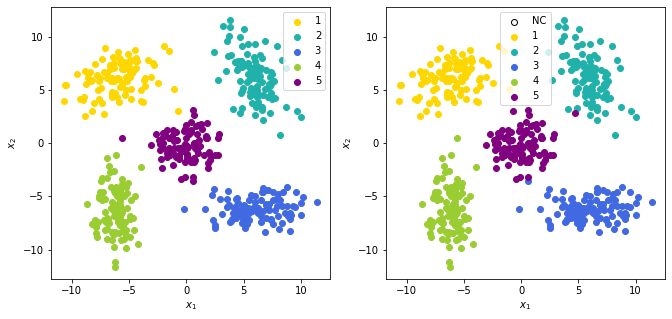

In [130]:
result=KNN.testing(data_app_1,data_test_1,k=k_opt,unanimite=1)
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°2 (KPPV una)

Déterminer le k optimale par 5CV

In [98]:
KNN=kppv()

fold_dataframe=folding_data(data_app_2,fold=5)
k_opt=KNN.cross_validation(fold_dataframe, fold=5, k_range=20, unanimite=1)
print("k*=",k_opt)

k*= 1


Tester la méthode avec le k optimale

Top 1 =  92.0


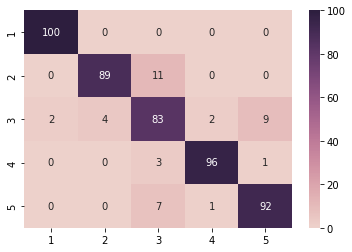

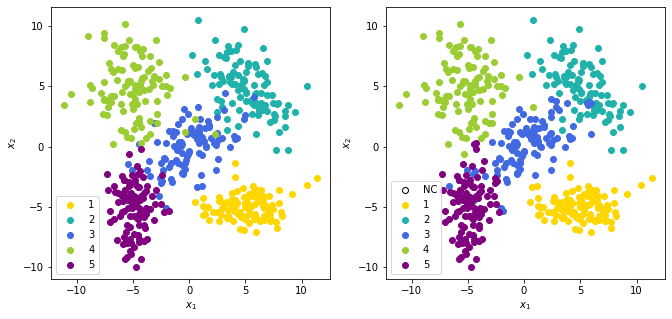

In [131]:
result=KNN.testing(data_app_2,data_test_2,k=k_opt,unanimite=1)
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°3 (KPPV una)

Déterminer le k optimale par 5CV

In [100]:
KNN=kppv()
fold_dataframe=folding_data(data_app_3,fold=5)
k_opt=KNN.cross_validation(fold_dataframe, fold=5, k_range=20, unanimite=1)
print("k*=",k_opt)

k*= 1


Tester la méthode avec le k optimale

Top 1 =  64.6


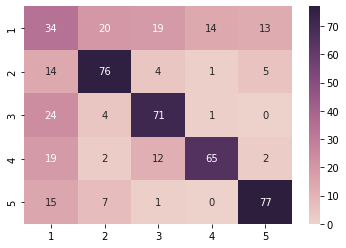

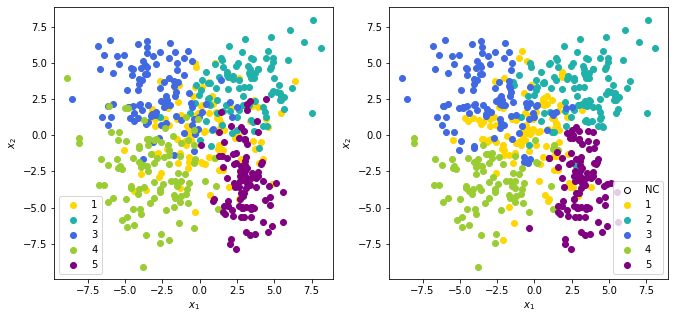

In [101]:
result=KNN.testing(data_app_3,data_test_3,k=k_opt,unanimite=1)
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Conclusion (KPPV una)

Le taux de prédiction avec vote à l'unanimité est données par $k=1$ pour les trois jeux de données. Cela s'explique par le fait que si $k>1$, il est difficile d'avoir un vote unanime et donc beaucoup d'exemples ne seront pas classifiés, ce qui ferait baisser le taux de bonnes prédictions. Avec $k=1$, on retrouve donc exactement les mêmes performances que la méthode du 1PPV.

### Comparaison KPPV (Majorité vs Unanimité)

Le 1PPV et le KPPV avec vote à l'unanimité donne exactement les mêmes résultats. Lorsqu'on compare le 1PPV au KPPV avec vote à la majorité, on s'attend que le KPPV est au moins les mêmes résultats que le 1PPV puisque 1PPV est un cas particulier du KPPV, ce qui est le cas dans nos tests.

En effet, KPPV avec vote à la majorité donne de meilleurs résultats que 1PPV sur les trois jeux de données.

Sur les données N°1 KPPV a 99.6% de précision pour $k=7$ contre 99.2% pour 1PPV.
Sur les données N°2 KPPV a 95.2% de précision pour $k=12$ contre 92% pour 1PPV
Enfin, sur les données N°3 KPPV a 69.6% de précision pour $k=8$ contre 64.6% pour 1PPV.

# 3. Fenètres de Parzen <a class="anchor" id="parzen"></a>

## code

In [9]:
def uniform_kernel(xi,x,h):
    if np.linalg.norm((xi-x)/h)<=1:
        return 1/h
    else:
        return 0
    
def gaussian_kernel(xi,x,h):
    return np.exp(-0.5*np.linalg.norm((xi-x)/h)**2)/(2*np.pi)

class parzen:
    def testing(self, learning_dataframe, testing_dataframe, kernel, h):
        n_test = testing_dataframe.index.size # récupérer le nombre d'exmples du dataset à classifier
        n_learn = learning_dataframe.index.size # récupérer le nombre d'exmples du dataset d'apprentissage
        n_classe = len(learning_dataframe.Classe.unique()) # récupérer le nombre de classes
        
        learning_dataframe.index=np.arange(n_learn) #réindexer les dataframe à partir de 0 dans le cas de cross validation
        testing_dataframe.index=np.arange(n_test)
        
        n_par_class=[]
        for k in range(n_classe): # déterminer le nombre d'élément de chaque classe
            n_par_class.append(len(learning_dataframe.loc[learning_dataframe.Classe==k+1].values))

        result=testing_dataframe.copy()
        C=np.zeros((n_test,n_classe))
        L_top1=[]
        L_top2=[]
        
        ### calculer la probabilité de chaque exemple à classifier par rapport aux exemples d'apprentissage ###
        for i in range(n_test):
            for j in range(n_learn):
                c=learning_dataframe.iloc[j,0]-1
                C[i,c]+=kernel(testing_dataframe.iloc[i,1:3].values,learning_dataframe.iloc[j,1:3].values,h)
            for k in range(n_classe):
                C[i,k]=C[i,k]/(n_par_class[k]*h)
        #######################################################################################################     
        
            if np.count_nonzero(C[i,:])==0: # si aucun exemple d'apprentissage n'est dans la fenetre de l'exemple à classifier ne pas classifier
                L_top1.append(0)
                L_top2.append([])
            elif np.count_nonzero(C[i,:])==1: # s'il y a des exemples d'apprentissage qui viennent d'une même, le top2 contient une seule classe
                L_top1.append(np.argmax(C[i,:])+1) # ajouter la classe au top1
                L_top2.append([np.argmax(C[i,:])+1]) # ajouter une seule classe au top2
            else: # calcul du top1 et du top2
                L_top1.append(np.argmax(C[i,:])+1)
                L_top2.append(np.argsort(C[i,:])[-1:-3:-1]+1)
            #print(C[i,:],L_top1[i])
            result['top1']=pd.Series(L_top1)
            result['top2']=pd.Series(L_top2)
        return result
    def cross_validation(self,folded_dataframe,h_range,kernel):
        top_fold=np.zeros(h_range*4) # faire la cross validation pour des valeur de h qui augmente de 0.25 pour chaque test
        nbr_classe=len(folded_dataframe.Classe.unique()) # récupérer le nombre de classes
        h_values=np.linspace(0.25, h_range,h_range*4) # h_values contient toutes les valeurs de h pour lesquelles l'agorithme va itérer
        h_index=np.arange(h_range*4) # l'index de chaque valeur de h_values
        for i in range(fold):
            for h, h_ind in zip(h_values,h_index):
                # faire des test en faisant des rotations sur les folds pour les différentes valeur de h
                result=parzen_window.testing(fold_dataframe.loc[fold_dataframe.fold != i,['Classe','x1','x2']], fold_dataframe.loc[fold_dataframe.fold == i,['Classe','x1','x2']],kernel,h=h)
                top_fold[h_ind]+=top_one(result) # calculer le taux de bonne prédiction pour chaque valeur de h
        return h_values[np.argmax(top_fold)] # retourne la valeur de h pour laquelle le taux de bonne prédiction moyen est le plus élévé

## Test Parzen

### Kernel uniforme test $(h=1)$ <a class="anchor" id="h1_uniform"></a>

#### Données N°1 (Parzen uniforme $h=1$)

Top 1 =  95.8
Top 2 =  95.8


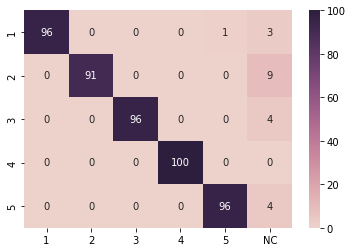

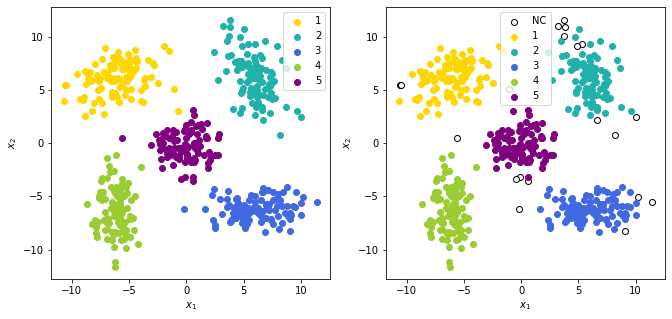

In [123]:
parzen_window=parzen()
result=parzen_window.testing(data_app_1,data_test_1,uniform_kernel,h=1)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°2 (Parzen uniforme $h=1$)

Top 1 =  91.4
Top 2 =  95.0


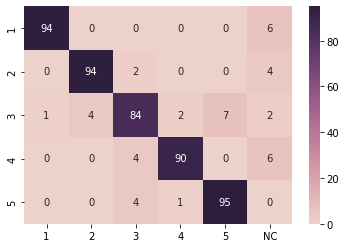

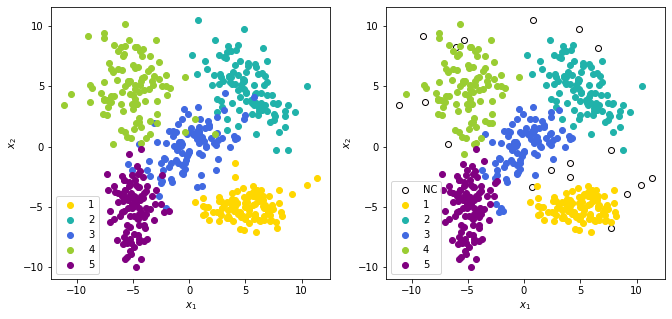

In [116]:
parzen_window=parzen()
result=parzen_window.testing(data_app_2,data_test_2,uniform_kernel,h=1)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°3 (Parzen uniforme $h=1$)

Top 1 =  64.60000000000001
Top 2 =  81.2


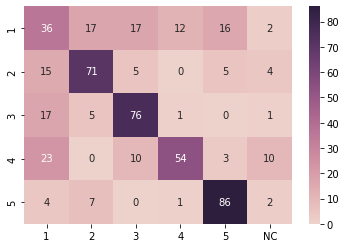

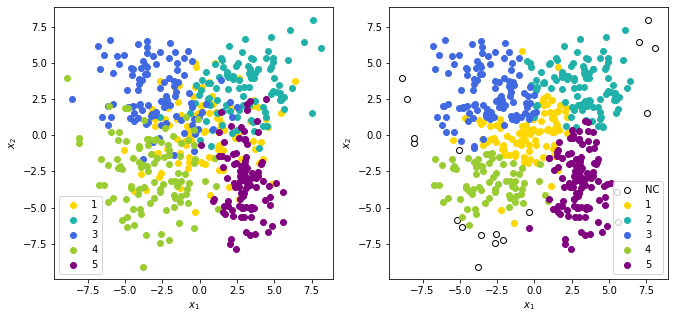

In [117]:
parzen_window=parzen()
result=parzen_window.testing(data_app_3,data_test_3,uniform_kernel,h=1)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

### Kernel gaussien test $(h=1)$ <a class="anchor" id="h1_gaussien"></a>

#### Données N°1 (pazen gauss $h=1$)

Top 1 =  99.6
Top 2 =  99.8


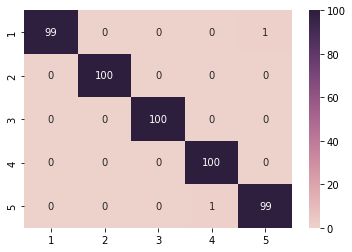

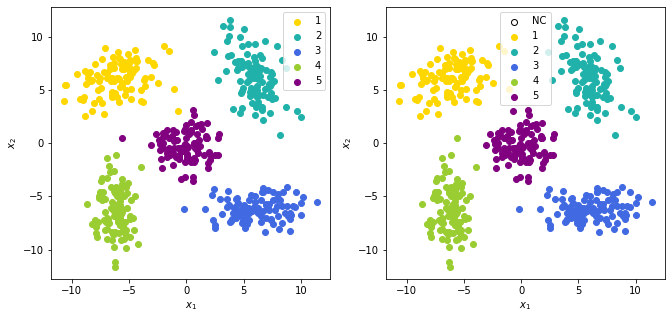

In [118]:
parzen_window=parzen()
result=parzen_window.testing(data_app_1,data_test_1,gaussian_kernel,h=1)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°2 (pazen gauss $h=1$)

Top 1 =  94.8
Top 2 =  99.4


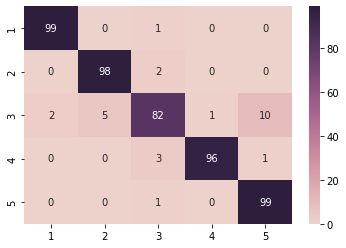

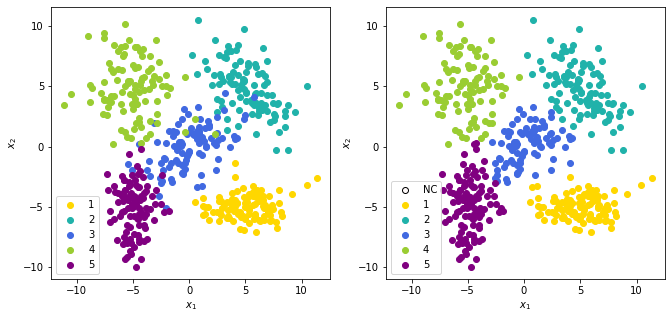

In [119]:
parzen_window=parzen()
result=parzen_window.testing(data_app_2,data_test_2,gaussian_kernel,h=1)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°3 (pazen gauss $h=1$)

Top 1 =  71.2
Top 2 =  86.4


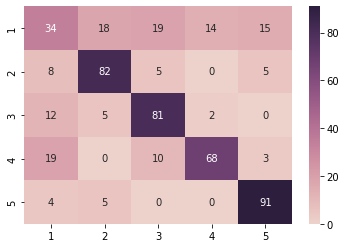

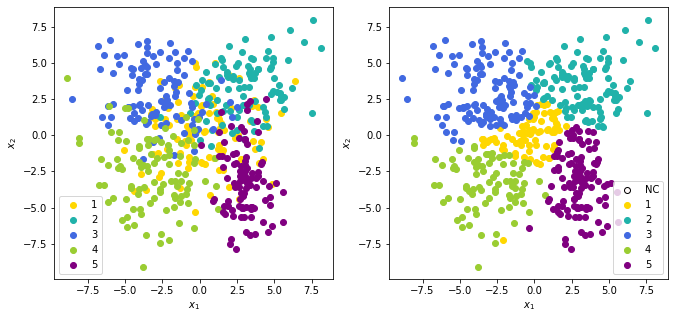

In [120]:
parzen_window=parzen()
result=parzen_window.testing(data_app_3,data_test_3,gaussian_kernel,h=1)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

### Conclusion (pazen $h=1$)

la méthode de parzen donne d'excellent résults pour les deux premiers jeux de données que ce soit pour le noyau uniform ou pour le noyau gaussien (plus de 99% pour les données N°1 et plus de 94% pour les données N°2).

Pour ce qui est des données N°3, le noyau gaussian a de meileurs résultat (71,2% en top 1) par rapport au noyau uniform (67,15%). En top 2, pour les données N°3 on a la même tendance avec un léger avantage pour le noyau gaussien (86,4% pour le noyau gaussien econtre 84,4 pour le noyau uniforme).

## Test Parzen avec $h$ optimal <a class="anchor" id="hopt"></a>

Pour le calcul de la probabilité que l'exemple $x$ appartienne à la classe $k$ nous utilisons la formule: $p(w=k|x)=\frac{1}{hN}\sum_i \phi(\frac{x-x_i}{h})$.

Pour le noyau uniforme 
$
\phi(\frac{x-x_i}{h})= \left\{
    \begin{array}{ll}
        \frac{1}{h} & \mbox{si } ||\frac{x-x_i}{h}||\leq 1\\
        0 & \mbox{sinon.}
    \end{array}
\right.
$

Pour le noyau gaussien $\phi(\frac{x-x_i}{h})=\frac{1}{2\pi}e^{\frac{-x^Tx}{h}}$

### Kernel uniforme <a class="anchor" id="hopt_uniform"></a>

#### Données N°1 (parzen uniforme)

Déterminer le $h$ optimale par 5CV

In [13]:
parzen_window=parzen()
fold=5
fold_dataframe=folding_data(data_app_1,fold) # diviser les données d'apprentissage en 5 sous ensembles
h_opt=parzen_window.cross_validation(fold_dataframe,h_range=2,kernel=uniform_kernel) # déterminer h avec un 5CV sur les données d'apprentissage
print("h*=",h_opt)

h*= 2.0


Tester avec la valeur de $h$ optimale

Top 1 =  99.0
Top 2 =  99.0


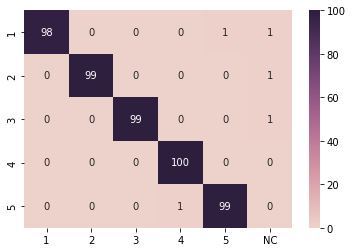

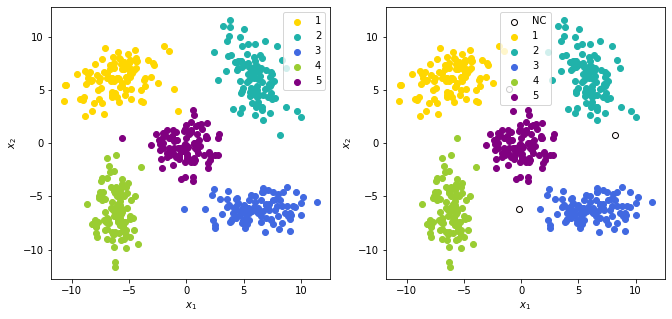

In [14]:
parzen_window=parzen()
result=parzen_window.testing(data_app_1,data_test_1,uniform_kernel,h=h_opt)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°2 (parzen uniforme)

Déterminer le $h$ optimale par 5CV

In [15]:
parzen_window=parzen()
fold=5
fold_dataframe=folding_data(data_app_2,fold)
h_opt=parzen_window.cross_validation(fold_dataframe,h_range=2,kernel=uniform_kernel)
print("h*=",h_opt)

h*= 1.75


Tester avec la valeur de $h$ optimale

Top 1 =  94.8
Top 2 =  99.0


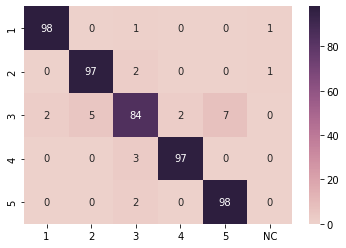

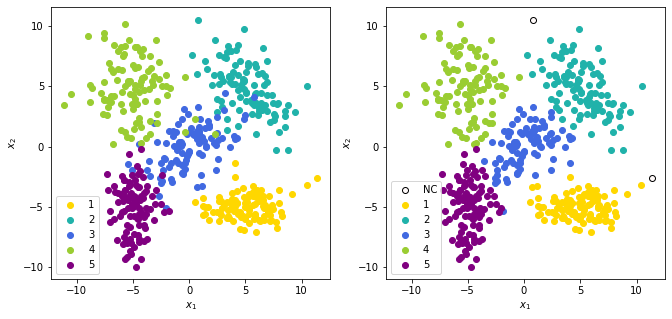

In [16]:
parzen_window=parzen()
result=parzen_window.testing(data_app_2,data_test_2,uniform_kernel,h=h_opt)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°3 (parzen uniforme) 

Déterminer le $h$ optimale par 5CV

In [17]:
parzen_window=parzen()
fold=5
fold_dataframe=folding_data(data_app_3,fold)
h_opt=parzen_window.cross_validation(fold_dataframe,h_range=2,kernel=uniform_kernel)
print("h*=",h_opt)

h*= 1.75


Tester avec la valeur de $h$ optimale

Top 1 =  70.0
Top 2 =  86.4


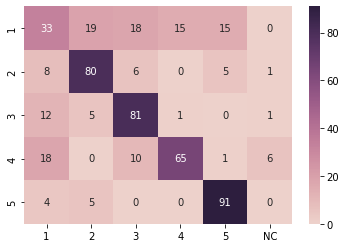

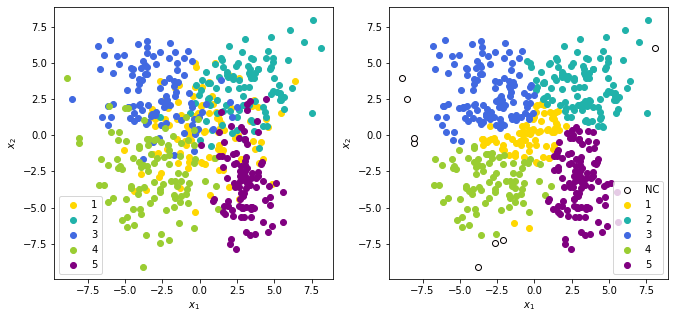

In [18]:
parzen_window=parzen()
result=parzen_window.testing(data_app_3,data_test_3,uniform_kernel,h=h_opt)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

### Kernel gaussien <a class="anchor" id="hopt_gaussien"></a>

#### Données N°1 (parzen gauss)

Déterminer le $h$ optimale par 5CV

In [108]:
parzen_window=parzen()
fold=5
fold_dataframe=folding_data(data_app_1,fold)
h_opt=parzen_window.cross_validation(fold_dataframe,h_range=2,kernel=gaussian_kernel)
print("h*=",h_opt)

h*= 1.75


Tester avec la valeur de $h$ optimale

Top 1 =  99.6
Top 2 =  99.8


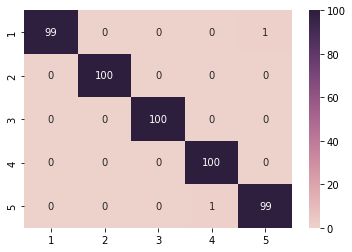

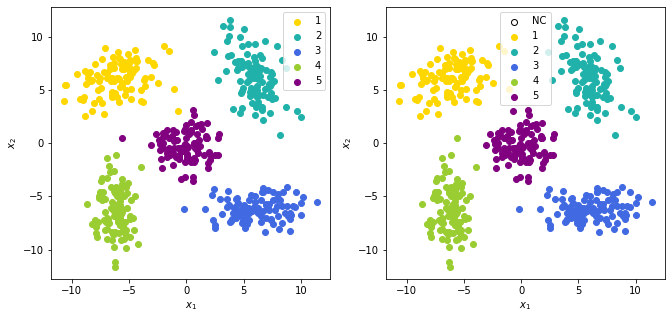

In [111]:
parzen_window=parzen()
result=parzen_window.testing(data_app_1,data_test_1,gaussian_kernel,h=h_opt)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°2 (parzen gauss)

Déterminer le $h$ optimale par 5CV

In [112]:
parzen_window=parzen()
fold=5
fold_dataframe=folding_data(data_app_2,fold)
h_opt=parzen_window.cross_validation(fold_dataframe,h_range=2,kernel=gaussian_kernel)
print("h*=",h_opt)

h*= 1.0


Tester avec la valeur de $h$ optimale

Top 1 =  94.8
Top 2 =  99.4


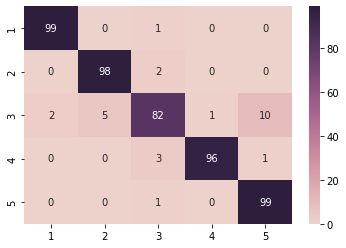

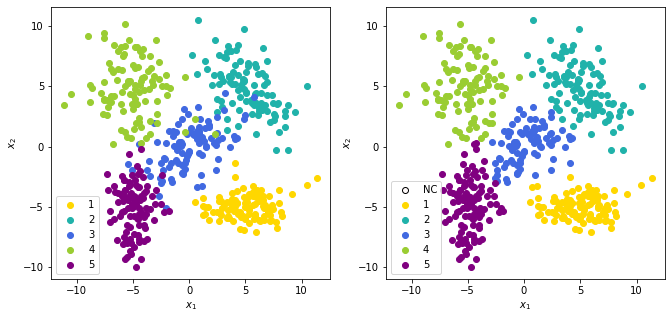

In [113]:
parzen_window=parzen()
result=parzen_window.testing(data_app_2,data_test_2,gaussian_kernel,h=h_opt)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°3 (parzen gauss)

Déterminer le $h$ optimale par 5CV

In [114]:
parzen_window=parzen()
fold=5
fold_dataframe=folding_data(data_app_3,fold)
h_opt=parzen_window.cross_validation(fold_dataframe,h_range=2,kernel=gaussian_kernel)
print("h*=",h_opt)

h*= 1.25


Tester avec la valeur de $h$ optimale

Top 1 =  72.39999999999999
Top 2 =  88.2


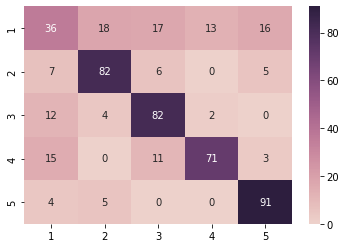

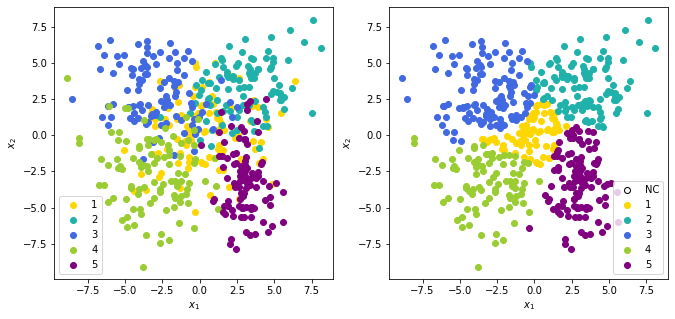

In [117]:
parzen_window=parzen()
result=parzen_window.testing(data_app_3,data_test_3,gaussian_kernel,h=h_opt)
print("Top 1 = ",top_one(result))
print("Top 2 = ",top_two(result))
mat_conf=mat_confusion(result)
visualize_data(result)

### Conclusion (parzen)

Sans surprise la méthode de Parzen pour les deux noyaux avec et les meilleures réglage de l'hyper paramètre $h$ donne d'excellet résultat pour le jeu de données N°1 (99.6% de bonne prédiction).

Pour les données N°2, on retrouve cette fois le noyau uniform qui donne légèrement un meilleur taux de bonne prédiction en top1 (95,38%) par rapport au noyau gaussien (94.8%).

Les des noyaux donne aussi de bon résultats pour les données N°3, avec 72,4% pour le noyau gaussien et 71,14% pour le noyau uniform. le taux de prédiction des deux méthodes en top 2 est très similaire (au allontour de 88% pour les deux noyaux).

### Comparaison et discution des hyper paramètres

En ajustant l'hyper paramètre $h$, les deux méthodes ont connu une amélioration, qui reste modérée pour le noyau gaussien mais importante pour le noyau uniforme.

Sur les données N°1, il n'y a pas de fluctuation puisque les deux méthodes donnaient déjà d'excellents résultats.

Pour ce qui est des données N°2, on note une amélioration sur le taux de prédiction en top 1 du noyau uniforme qui passe de 91.4% ($h=1$) à 94.8% ($h=1,5$), on note aucune amélioration pour le noyau gaussien.

Sur les données N°3, les deux noyaux ont une amélioration sur leur taux de prédiction en top 1 avec les bons paramètres. Le noyau gaussien passe de 71,2% ($h=1$) à 72,4% ($h=1,25$). Pour le noyau uniforme on note une nette amélioration avec un taux de prédiction qui passe de 64.6% ($h=1$) à 70% ($h=2$)

# 4. Séparation linéaire <a class="anchor" id="SL"></a>

### Code

In [264]:
def perceptron_separable(X1, X2): # algorithme du perseptron pour les cas linéairement séparables
    n1=X1.shape[0]
    n2=X2.shape[0]
    Y=np.vstack((np.c_[X1,np.ones(n1)],-1*np.c_[X2,np.ones(n2)])) # transofrmation des données
    d=X1.shape[1] # récupérer la dimension des données
    n=Y.shape[0] # récupérer le nombre d'exemles des deux classes à séparer
    a=np.ones(d+1) # créer le vecteur a de dimension d+1
    test=True
    while(test): # reperer jusqu'à ce que toute les points soient en dessous de l'hyperplan définit par a
        test=False
        for i in range(n):
            if a.T@Y[i,:]<=0: # si un exemple n'est pas en dessous du plan le rajouter à a
                a+=Y[i,:]
                test=True
    return a # retourner l'hyperplan


# dans le cas non linéaire il est important de rajouer un coeficient d'erreurs epsilon qui va autoriser un certain taux de mauvaises
# prédictions. cette méthodes va donc séparer les deux classes même si elles ne sont pas linéairement séparables. Mais quelle valeur
# de epsilon choisir? Nous commencons dont par la valeur epsilon=0 et si l'algorithme ne converge pas au bout d'un certain 
# nombre d'itérations augmenter progressivement la valeur de epsilon jusqu'à ce que le taux d'erreurs soit assez élevés pour 
# permet à l'algorithme de converger.
def perceptron_non_separable(X1, X2):
    n1=X1.shape[0]
    n2=X2.shape[0]
    Y=np.vstack((np.c_[X1,np.ones(n1)],-1*np.c_[X2,np.ones(n2)]))
    d=X1.shape[1]
    n=Y.shape[0]
    a=np.ones(d+1)
    test=True
    iter=0
    epsilon=0
    while(test):
        iter+=1
        test=False
        if iter>n: # si le nombre d'itération dépasse un certain seuil (dans notre cas ce sera le nombre d'exemple)
            iter=0 # réinitialiser le compteur d'iteration
            epsilon+=0.25 # augmenter de 0.25 la valeur de episilon
        for i in range(n):
            if a.T@Y[i,:]<=-epsilon:
                a+=Y[i,:]
                test=True
    return a

class separation_lineaire:
    def learning_1vs1(self,learning_dataframe,perceptron_method): # methode pour faire l'apprentissage 1 vs 1
        n_class=len(learning_dataframe.Classe.unique()) # récuperer le nombre de classes
        a=np.zeros((n_class,n_class,3)) # a va contenir tous les hyperplan
        #pour chaque pair de classes déterminer l'hyper plan qui permet de les séparer
        for i in range(n_class):
            X1=learning_dataframe.loc[learning_dataframe.Classe == i+1,['x1','x2']].values
            for j in range(i+1,n_class,1):
                X2=learning_dataframe.loc[learning_dataframe.Classe == j+1,['x1','x2']].values
                a[i,j,:]=perceptron_method(X1, X2) # on peut choisir la méthode perceptron_séparable ou perceptron_non_separable
                a[j,i,:]=a[i,j,:]
        return a
    def learning_1vsall(self,learning_dataframe,perceptron_method): #methode qui permet de faire l'apprentissage 1 vs all
        n_class=len(learning_dataframe.Classe.unique()) # récupérer le nombre de classes
        a=np.zeros((n_class,3)) # a va contenir tous les hyperplan
        for i in range(n_class): # pour chaque classe
            X1=learning_dataframe.loc[learning_dataframe.Classe == i+1,['x1','x2']].values # x1 va contenir les exemples de la classe séléctionnée
            X2=learning_dataframe.loc[learning_dataframe.Classe != i+1,['x1','x2']].values # x2 va contenir tous le reste des exemples
            a[i,:]=perceptron_method(X1, X2) # calculer l'hyperplan qui sépare les exemples de la classes séléctionnée des autres exemples
        return a # retourner a qui contient tout les hyperplan
    
    def classify_1vs1(self,testing_dataframe,a): # methode pour classifier les exemple dans le cas 1 vs 1
        n=testing_dataframe.index.size # récupérer le nombre d'exemple à classifier
        n_class=len(testing_dataframe.Classe.unique()) # récupère le nombre de classes
        vote=np.zeros((n,n_class)) # va contenir les votes par rapport à chaque hyper plan
        result=testing_dataframe.copy()
        X=np.c_[testing_dataframe.iloc[:,1:3].values,np.ones(n)] # au lieu de tranformer a en u et u0 il est plus pratique de rajouter une colonnes de 1 pour faire les conparaison
        L=[]
        # pour chque exemple à classifier
        for i in range(n):
            # pour chaque hyperplan
            for j in range(n_class):
                for k in range(j+1,n_class,1):
                    if (a[j,k,:]@X[i,:]>=0): # si le point est au dessus de l'hyper plan alors on vote (+1) pour la classes à qui il appartient par rapport à l'hyperplan
                        vote[i,j]+=1
                    else: # sinon on vote (+1) pour l'autre classe
                        vote[i,k]+=1
            vote[i,:]-=np.min(vote[i,:]) # pour chaque exemple on soustrait le vote le plus petit (si par exemple les votes donnent [2,2,2,2,2] nous autont [0,0,0,0,0] ce qui est pratique
            if np.count_nonzero(vote[i,:])==0: # si tout les votes sont identiques on se trouve donc dans une région indéterminé et il est impossible de classifier l'exemple
                L.append(0)
            else: # si dans le vote ya une classe qui se distingue on choisit cette classe pour classifier l'exemple
                L.append(np.argmax(vote[i,:])+1)
        result['top1']=pd.Series(L)
        return result
        
    def classify_1vsall(self,testing_dataframe,a): # methode pour classifier les exemples dans le cas 1 vs all
        n=testing_dataframe.index.size # récupérer le nombre d'exemple à classifier
        n_class=len(testing_dataframe.Classe.unique()) # récupérer le nombre de classe
        L_top1=np.ones(n)*-1 # valeur initial de la classification à -1
        result=testing_dataframe.copy()
        X=np.c_[testing_dataframe.iloc[:,1:3].values,np.ones(n)]
        # pour chaque exemple à classifier
        for i in range(n):
            # pour chaque hyperplan
            for j in range(n_class):
                if a[j,:]@X[i,:]>0: # si l'exemple appartient à la classe j par rapport à l'hyperplan on fait un autre test pour savoir si l'exemple appartient bien à la classe j ou à une région d'amguité
                    if L_top1[i] == -1: # si l'exemple n'a pas été affecté à une autre classe l'affecter à j
                        L_top1[i]=j+1
                    else: L_top1[i]=0 # si l'exemple appartient déjà à une autre classe, on se trouve dans une région d'ambiguité et on ne classe pas l'exemple
            if L_top1[i]==-1: # si aucun exemple n'est classifié (zone indéterminer) on le garde non classifier (ou l'affecter à la classe 0)
                L_top1[i]=0
        result['top1']=pd.Series(np.ndarray.tolist(L_top1))
        return result

## One vs One <a class="anchor" id="1v1"></a>

### Apprentissage du perceptron

#### Données N°1 (1 vs 1)

Top 1 =  99.0


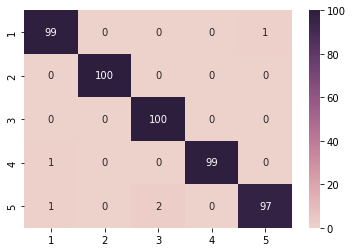

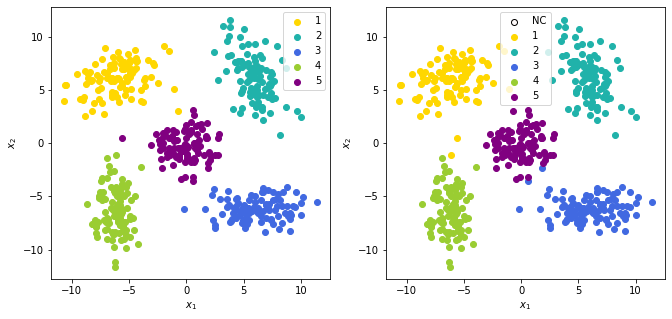

In [120]:
SL=separation_lineaire()
a=SL.learning_1vs1(data_app_1,perceptron_separable)
result=SL.classify_1vs1(data_test_1,a)
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

### Adaptation du perceptron pour les classes non séparables linéairement (données N°2 et N°3)

#### Données N°2 (1 vs 1)

Top 1 =  89.8


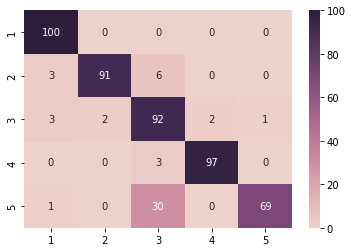

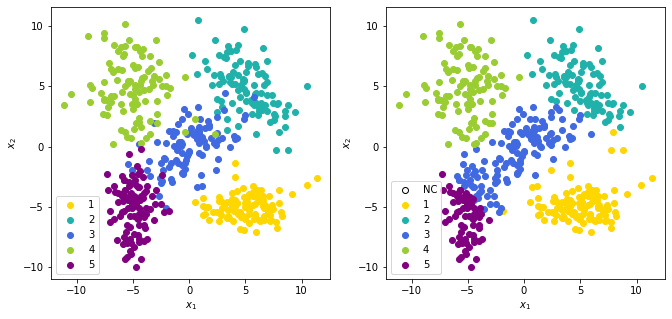

In [121]:
SL=separation_lineaire()
a=SL.learning_1vs1(data_app_2,perceptron_non_separable)
result=SL.classify_1vs1(data_test_2,a)
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°3 (1 vs 1)

Top 1 =  59.4


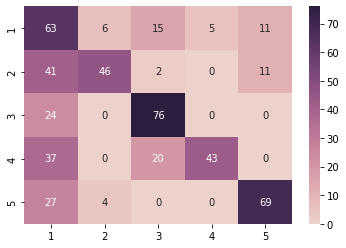

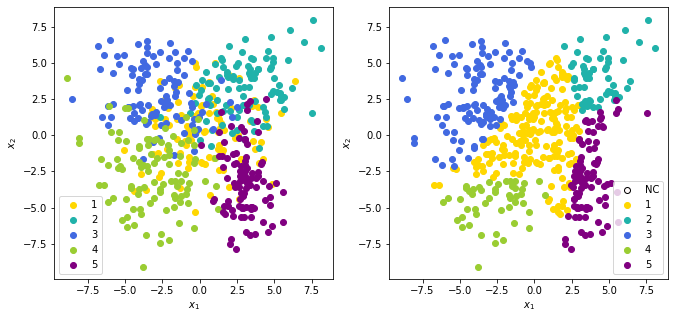

In [263]:
SL=separation_lineaire()
a=SL.learning_1vs1(data_app_3,perceptron_non_separable)
result=SL.classify_1vs1(data_test_3,a)
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

## One vs All <a class="anchor" id="1vall"></a>

### Suppression des classes centrales

In [151]:
# suppression de la calsse centrale avec ajustement des index et du numéro des classes
data_app_1_copy=data_app_1.loc[data_app_1.Classe != 5].copy()
data_test_1_copy=data_test_1.loc[data_test_1.Classe != 5].copy()

X_app=data_app_2.loc[data_app_2.Classe != 3,['Classe','x1','x2']].values
X_test=data_test_2.loc[data_test_2.Classe != 3,['Classe','x1','x2']].values
for i in range(X_app.shape[0]):
    if X_app[i,0]>=3:
        X_app[i,0]-=1
        X_test[i,0]-=1
data_app_2_copy=pd.DataFrame(X_app,columns=['Classe','x1','x2'])
data_test_2_copy=pd.DataFrame(X_test,columns=['Classe','x1','x2'])

X_app=data_app_3.loc[data_app_3.Classe != 1,['Classe','x1','x2']].values
X_test=data_test_3.loc[data_test_3.Classe != 1,['Classe','x1','x2']].values
X_app[:,0]-=1
X_test[:,0]-=1
data_app_3_copy=pd.DataFrame(X_app,columns=['Classe','x1','x2'])
data_test_3_copy=pd.DataFrame(X_test,columns=['Classe','x1','x2'])

#### Données N°1 (1 vs all)

Top 1 =  97.0


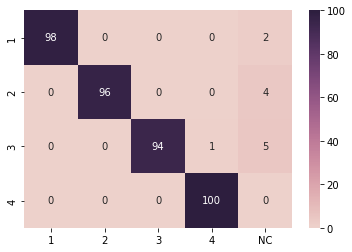

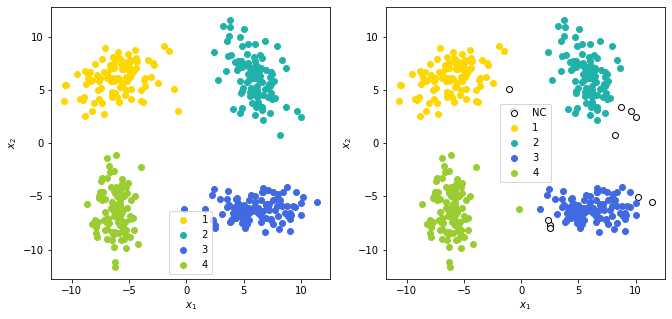

In [255]:
SL=separation_lineaire()
a=SL.learning_1vsall(data_app_1_copy,perceptron_non_separable)
result=SL.classify_1vsall(data_test_1_copy,a)
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°2 (1 vs all)

Top 1 =  90.5


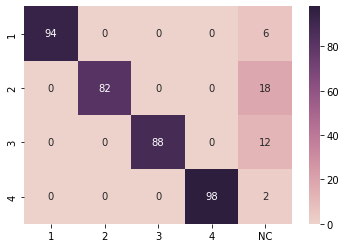

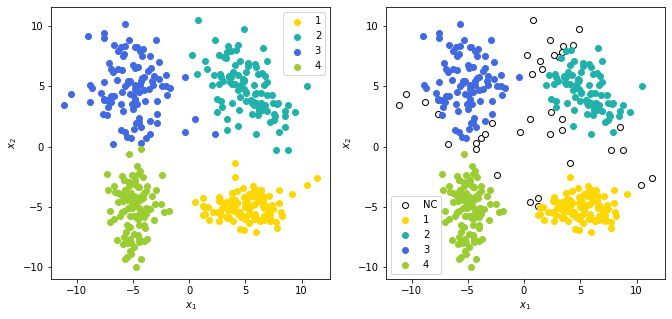

In [256]:
SL=separation_lineaire()
a=SL.learning_1vsall(data_app_2_copy,perceptron_non_separable)
result=SL.classify_1vsall(data_test_2_copy,a)
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°3 (1 vs all)

Top 1 =  55.25


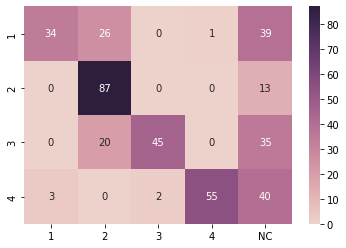

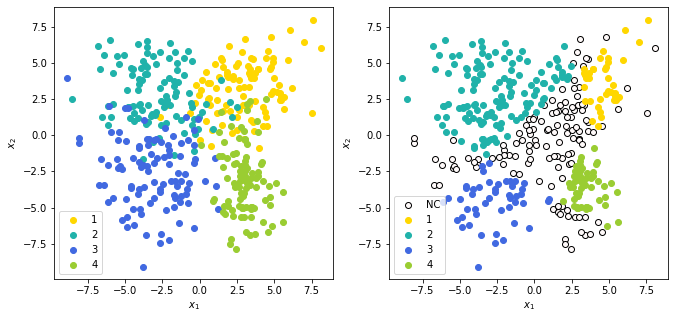

In [257]:
SL=separation_lineaire()
a=SL.learning_1vsall(data_app_3_copy,perceptron_non_separable)
result=SL.classify_1vsall(data_test_3_copy,a)
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

### Conclusion séparation linéaire

Comme son nom l'indique le classifieur par séparation linéaire donne d'excellent résultats lorsque les classes sont linéairement séparable (Données N°1).

Cependant, lorsque les données ne sont plus séparables linéairement, nous devons ajuster l'algorithme en permettant un taux d'erreurs afin qu'il converge, ce qui ne présage pas un taux de bonnes prédictions très élevé. De plus, nous savons que pour le classifieur par réparation linéaire (particulièrement pour le cas 1 vs all) nous avons des zones indéteminées et des zones d'anguitées où il est impossible de classifier les exemples ce qui ferait baisser davantage le taux de bonne prédiction.

Et en effet sur les données N°2, les deux approches (1vs1 et 1vsall) donnent un taux de bonne prédiction $\approx$90% ce qui n'est pas fameux compte tenu des autres approches déjà implémentées. Sur les données N°3, l'approche 1vs1 s'en sort un peu mieux que 1vsall avec un taux de bonne prédiction de 59.4% contre 55.25%.

## SVM <a class="anchor" id="SVM"></a>

### SVM Linéaire

Top 1 =  99.4


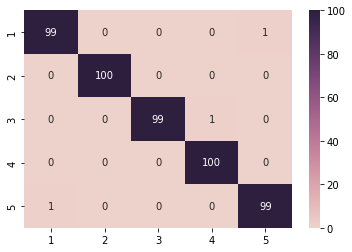

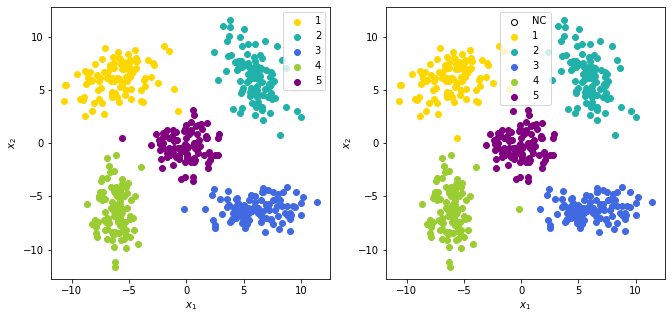

In [277]:
svm=LinearSVC(max_iter=5000)
X_train=data_app_1.iloc[:,1:3].values
y_train=data_app_1.iloc[:,0].values
X_test=data_test_1.iloc[:,1:3].values
y_test=data_test_1.iloc[:,0].values
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

### Noyau linéaire $C=1.0$

#### Données N°1 (lin)

Top 1 =  99.8


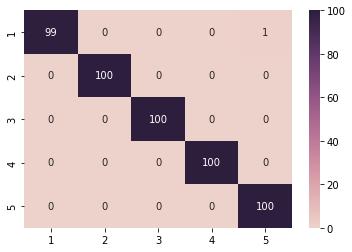

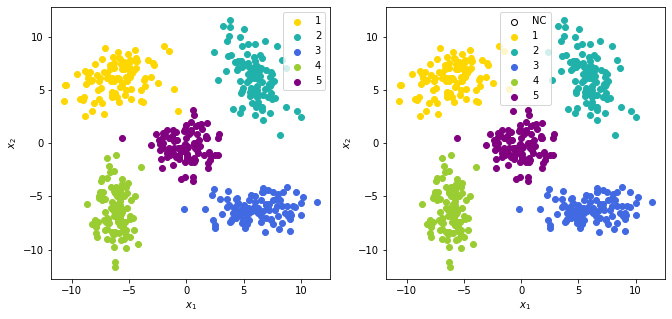

In [186]:
svm=SVC(kernel='linear',C=1.)
X_train=data_app_1.iloc[:,1:3].values
y_train=data_app_1.iloc[:,0].values
X_test=data_test_1.iloc[:,1:3].values
y_test=data_test_1.iloc[:,0].values
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°2 (lin)

Top 1 =  96.0


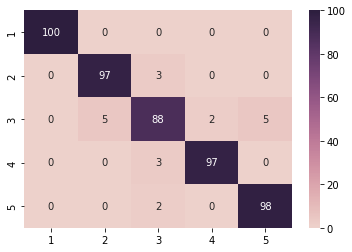

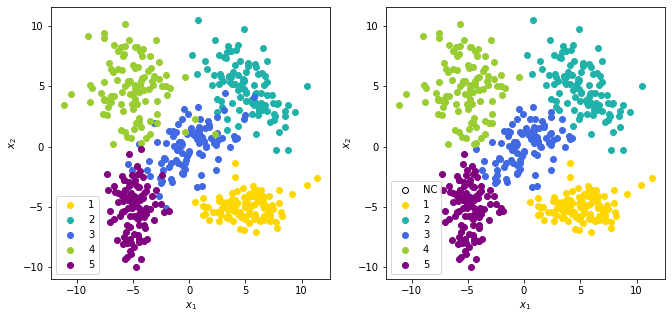

In [187]:
svm=SVC(kernel='linear',C=1.)
X_train=data_app_2.iloc[:,1:3].values
y_train=data_app_2.iloc[:,0].values
X_test=data_test_2.iloc[:,1:3].values
y_test=data_test_2.iloc[:,0].values
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

### Noyau RBF, $C=1.0$, $\gamma = 0.7$

#### Données N°1 (rbf)

Top 1 =  100.0


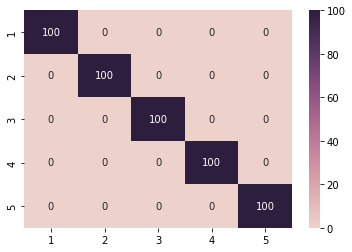

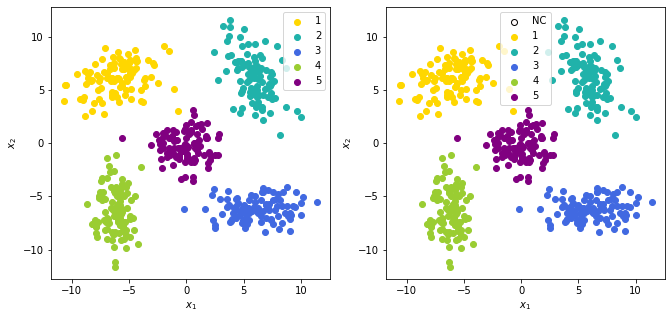

In [266]:
svm=SVC(kernel='rbf',C=1., gamma=.7)
X_train=data_app_1.iloc[:,1:3].values
y_train=data_app_1.iloc[:,0].values
X_test=data_test_1.iloc[:,1:3].values
y_test=data_test_1.iloc[:,0].values
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°2 (rbf)

Top 1 =  96.2


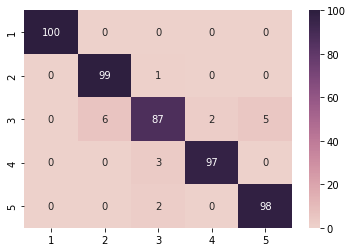

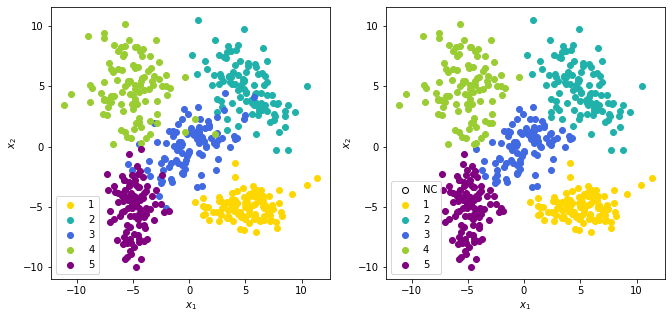

In [190]:
svm=SVC(kernel='rbf',C=1., gamma=.7)
X_train=data_app_2.iloc[:,1:3].values
y_train=data_app_2.iloc[:,0].values
X_test=data_test_2.iloc[:,1:3].values
y_test=data_test_2.iloc[:,0].values
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

### Noyau Polynomial, $C=1.0$, $degré= 0.7$

#### Données N°1 (poly)

Top 1 =  98.2


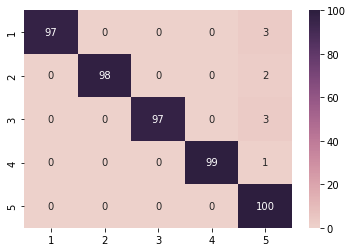

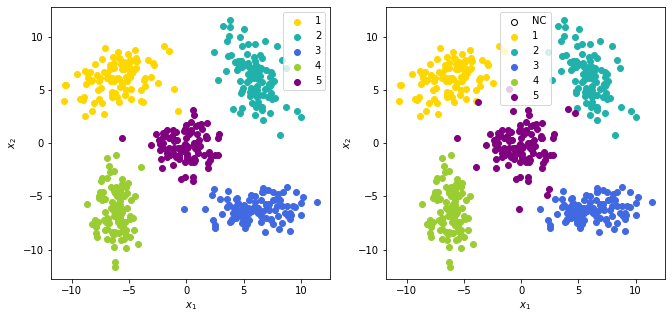

In [192]:
svm=SVC(kernel='poly',C=1., degree=3)
X_train=data_app_1.iloc[:,1:3].values
y_train=data_app_1.iloc[:,0].values
X_test=data_test_1.iloc[:,1:3].values
y_test=data_test_1.iloc[:,0].values
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Données N°2 (poly)

Top 1 =  93.4


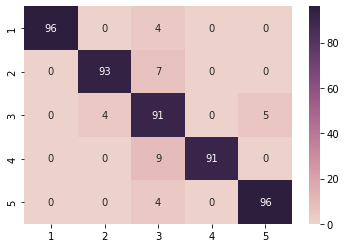

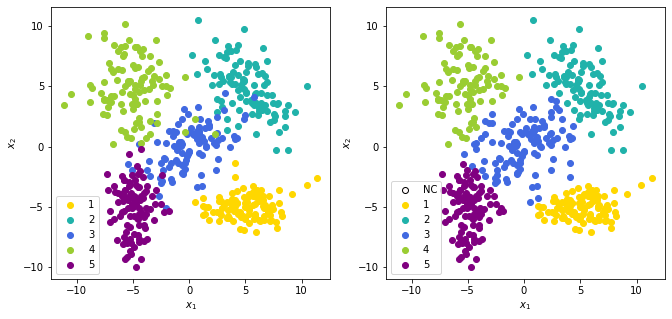

In [193]:
svm=SVC(kernel='poly',C=1., degree=3)
X_train=data_app_2.iloc[:,1:3].values
y_train=data_app_2.iloc[:,0].values
X_test=data_test_2.iloc[:,1:3].values
y_test=data_test_2.iloc[:,0].values
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

### Définir les paramètres pour chaque noyau

#### Noyau Linéaire : Données N°1

In [5]:
X_train=data_app_1.iloc[:,1:3].values
y_train=data_app_1.iloc[:,0].values
X_test=data_test_1.iloc[:,1:3].values
y_test=data_test_1.iloc[:,0].values

top1=np.zeros(30)
for c in range(30): # varier la valeur de C entre 0,1 et 3,0 avec un pas de 0,1
    SVM = SVC(kernel='linear',C=(c+1)/10) # entrainer le modele pour la valeur de c
    top1[c] = cross_val_score(SVM, X_train, y_train, cv = 5).mean() # 5CV
c=(np.argmax(top1)+1)/10 # retourner la valeur de c qui donne le taux de bonne prédiction moyen le plus élevé
print("C*=",c)

C*= 0.1


Top 1 =  99.8


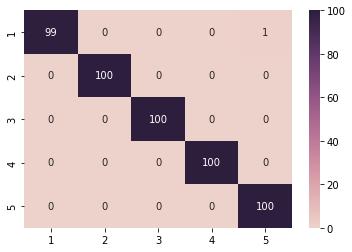

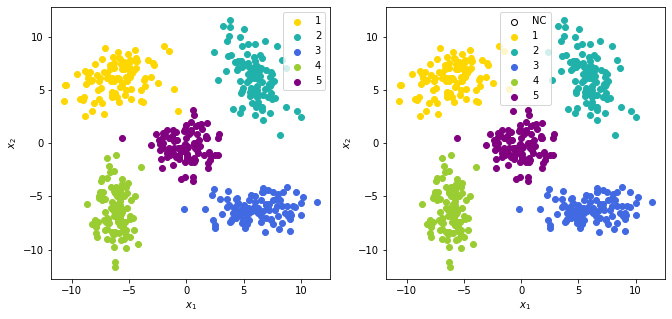

In [6]:
svm=SVC(kernel='linear',C=c)
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Noyau linéair : Données N°2

In [7]:
X_train=data_app_2.iloc[:,1:3].values
y_train=data_app_2.iloc[:,0].values
X_test=data_test_2.iloc[:,1:3].values
y_test=data_test_2.iloc[:,0].values

top1=np.zeros(30)
for c in range(30): # varier la valeur de C entre 0,1 et 3,0 avec un pas de 0,1
    SVM = SVC(kernel='linear',C=(c+1)/10)
    top1[c] = cross_val_score(SVM, X_train, y_train, cv = 5).mean() # 5CV
c=(np.argmax(top1)+1)/10
print("C*=",c)

C*= 0.1


Top 1 =  96.0


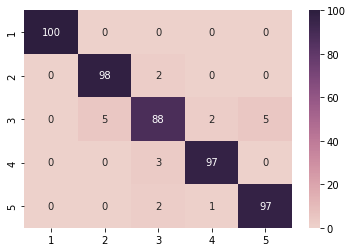

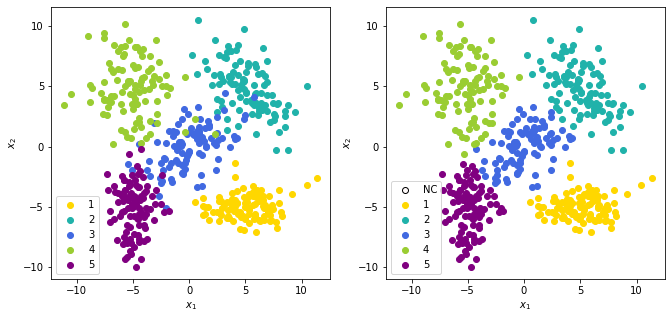

In [8]:
svm=SVC(kernel='linear',C=c)
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Noyau RBF : Données N°1

In [251]:
X_train=data_app_1.iloc[:,1:3].values
y_train=data_app_1.iloc[:,0].values
X_test=data_test_1.iloc[:,1:3].values
y_test=data_test_1.iloc[:,0].values

top1=np.zeros((30,30))
for c in range(30): # varier la valeur de C entre 0,1 et 3,0 avec un pas de 0,1
    for g in range(30): # varier la valeur de gamma entre 0,1 et 3,0 avec un pas de 0,1
        SVM = SVC(kernel='rbf',C=(c+1)/10,gamma=(g+1)/10)
        top1[c,g] = cross_val_score(SVM, X_train, y_train, cv = 5).mean() # 5CV
top1=np.ravel(top1)
ind=np.argmax(top1)
c=(ind//30 + 1)/10
d= (ind % 30 + 1)/10
print("C*=",c)
print("gamma*=",d)

C*= 0.2
gamma*= 0.2


Top 1 =  100.0


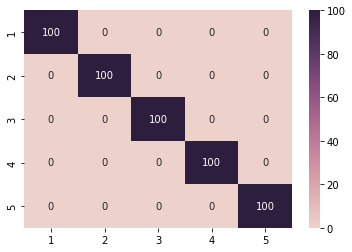

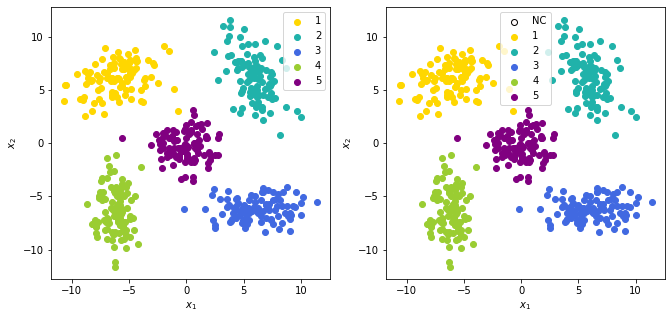

In [252]:
svm=SVC(kernel='rbf',C=c,gamma=g)
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Noyau RBF : Données N°2

In [269]:
X_train=data_app_2.iloc[:,1:3].values
y_train=data_app_2.iloc[:,0].values
X_test=data_test_2.iloc[:,1:3].values
y_test=data_test_2.iloc[:,0].values

top1=np.zeros((30,30))
for c in range(30): # varier la valeur de C entre 0,1 et 3,0 avec un pas de 0,1
    for g in range(30): # varier la valeur de gamma entre 0,1 et 3,0 avec un pas de 0,1
        SVM = SVC(kernel='rbf',C=(c+1)/10,gamma=(g+1)/10)
        top1[c,g] = cross_val_score(SVM, X_train, y_train, cv = 5).mean() # 5CV
top1=np.ravel(top1)
ind=np.argmax(top1)
c=(ind//30 + 1)/10
d= (ind % 30 + 1)/10
print("C*=",c)
print("gamma*=",d)

C*= 0.1
gamma*= 0.1


Top 1 =  99.6


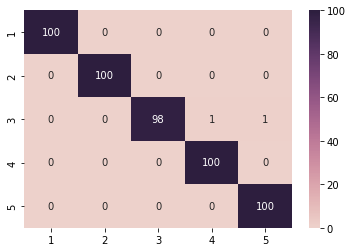

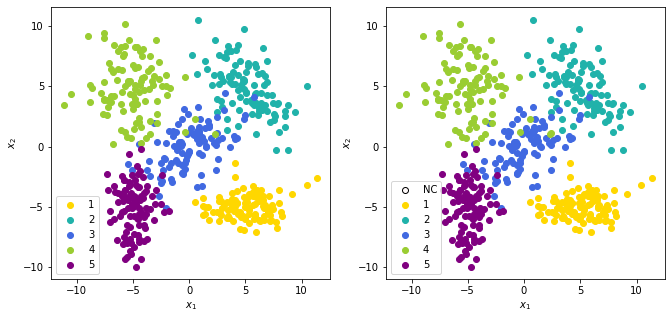

In [270]:
svm=SVC(kernel='rbf',C=c,gamma=g)
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Noyau Polynomial : Données N°1

In [236]:
X_train=data_app_1.iloc[:,1:3].values
y_train=data_app_1.iloc[:,0].values
X_test=data_test_1.iloc[:,1:3].values
y_test=data_test_1.iloc[:,0].values

top1=np.zeros((30,4))
deg=[2,3,4,5]
for c in range(30): # varier la valeur de C entre 0,1 et 3,0 avec un pas de 0,1
    for d in range(4): # varié le degré entre 2 et 5
        SVM = SVC(kernel='poly',C=(c+1)/10,degree=deg[d])
        top1[c,d] = cross_val_score(SVM, X_train, y_train, cv = 5).mean() # 5CV
top1=np.ravel(top1)
ind=np.argmax(top1)
c=(ind//4 + 1)/10
d= deg[ind % 4]
print("C*=",c)
print("d*=",d)

C*= 0.6
d*= 3


Top 1 =  98.2


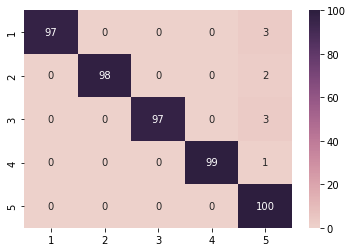

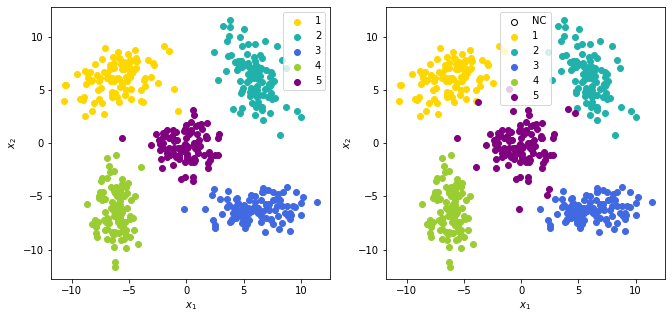

In [235]:
svm=SVC(kernel='poly',C=c,degree=d)
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)

#### Noyau polynomial : Données N°2

In [239]:
X_train=data_app_2.iloc[:,1:3].values
y_train=data_app_2.iloc[:,0].values
X_test=data_test_2.iloc[:,1:3].values
y_test=data_test_2.iloc[:,0].values

top1=np.zeros((30,4))
deg=[2,3,4,5]
for c in range(30): # varier la valeur de C entre 0,1 et 3,0 avec un pas de 0,1
    for d in range(4): # varié le degré entre 2 et 5
        SVM = SVC(kernel='poly',C=(c+1)/10,degree=deg[d])
        top1[c,d] = cross_val_score(SVM, X_train, y_train, cv = 5).mean() # 5CV
top1=np.ravel(top1)
ind=np.argmax(top1)
c=(ind//4 + 1)/10
d= deg[ind % 4]
print("C*=",c)
print("d*=",d)

C*= 1.3
d*= 3


Top 1 =  93.8


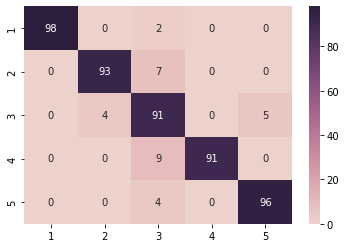

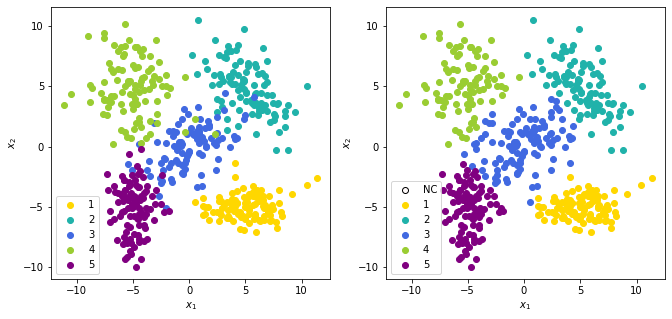

In [238]:
svm=SVC(kernel='poly',C=c,degree=d)
svm=svm.fit(X_test,y_test)
top1=svm.predict(X_test)

result=pd.DataFrame(np.c_[y_test, X_test, top1, top1],columns=['Classe','x1','x2','top1','top2'])
print("Top 1 = ",top_one(result))
mat_conf=mat_confusion(result)
visualize_data(result)